# Notebook 03: Dimensionality Reduction & Visualization

**Objective**: Visualize high-dimensional single-cell data in 2D space.

## What you will learn:
- Interpret PCA results (already computed in Notebook 02)
- Compute neighborhood graph
- UMAP for 2D visualization
- t-SNE as alternative visualization
- Compare UMAP vs t-SNE

## The Curse of Dimensionality

**Current state**: 2,689 cells in 50-dimensional PCA space
- Still too many dimensions to visualize
- Need to reduce to 2D for plotting

**Goal**: Project cells into 2D while preserving biological relationships

## Workflow:
1. Load preprocessed data (with PCA)
2. Visualize PCA variance and loadings
3. Build neighborhood graph
4. Compute UMAP (2D projection)
5. Compute t-SNE (alternative 2D projection)
6. Compare visualizations
7. Save results

In [7]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Preprocessed Data

Load the data from Notebook 02, which already contains:
- Log-normalized expression
- Highly variable genes identified
- **PCA already computed** (50 components)

In [8]:
# Load preprocessed data
adata = sc.read_h5ad(f'{data_dir}pbmc3k_preprocessed.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"Dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")
print(f"PCA components: {adata.obsm['X_pca'].shape[1]}")

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
Dimensions: 2689 cells × 13671 genes
Highly variable genes: 2000
PCA components: 50


## 2. Visualize PCA Results

PCA was already computed in Notebook 02. Let's visualize the variance explained by each component.

### Understanding Variance Explained

- **High variance PCs**: Capture major biological variation
- **Low variance PCs**: Mostly technical noise
- **Elbow point**: Where variance plateaus (typically around 20-30 PCs)

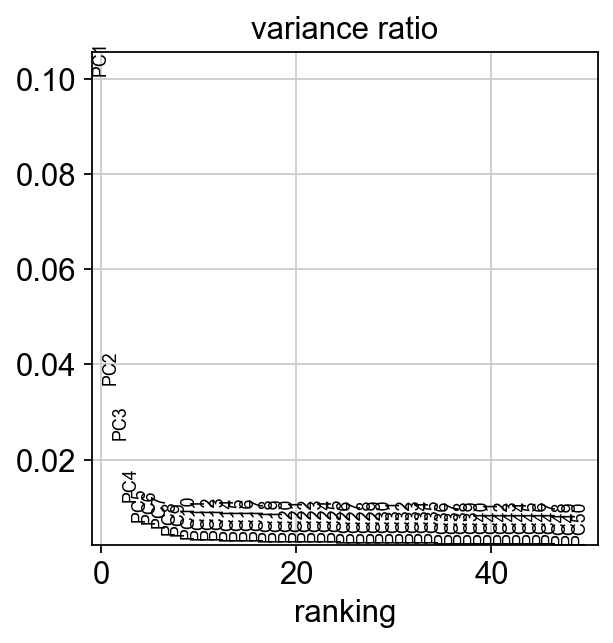


📊 Variance explained:
  - First 10 PCs: 20.3%
  - First 20 PCs: 23.3%
  - First 30 PCs: 26.0%
  - First 50 PCs: 30.8%


In [9]:
# Plot variance ratio
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False, show=False)
plt.savefig(f'{results_dir}03_pca_variance_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

# Print cumulative variance
cumvar = np.cumsum(adata.uns['pca']['variance_ratio'])
print(f"\n📊 Variance explained:")
print(f"  - First 10 PCs: {cumvar[9]:.1%}")
print(f"  - First 20 PCs: {cumvar[19]:.1%}")
print(f"  - First 30 PCs: {cumvar[29]:.1%}")
print(f"  - First 50 PCs: {cumvar[49]:.1%}")

## 3. Elbow Plot - Choosing Number of PCs

The elbow plot helps choose how many PCs to use for downstream analysis.

**Rule of thumb**: Use PCs before the elbow (where curve flattens).

The elbow plot is a helpful visualization — but not a strict decision rule.
Combine it with statistical testing and biological sanity checks for a more robust choice.

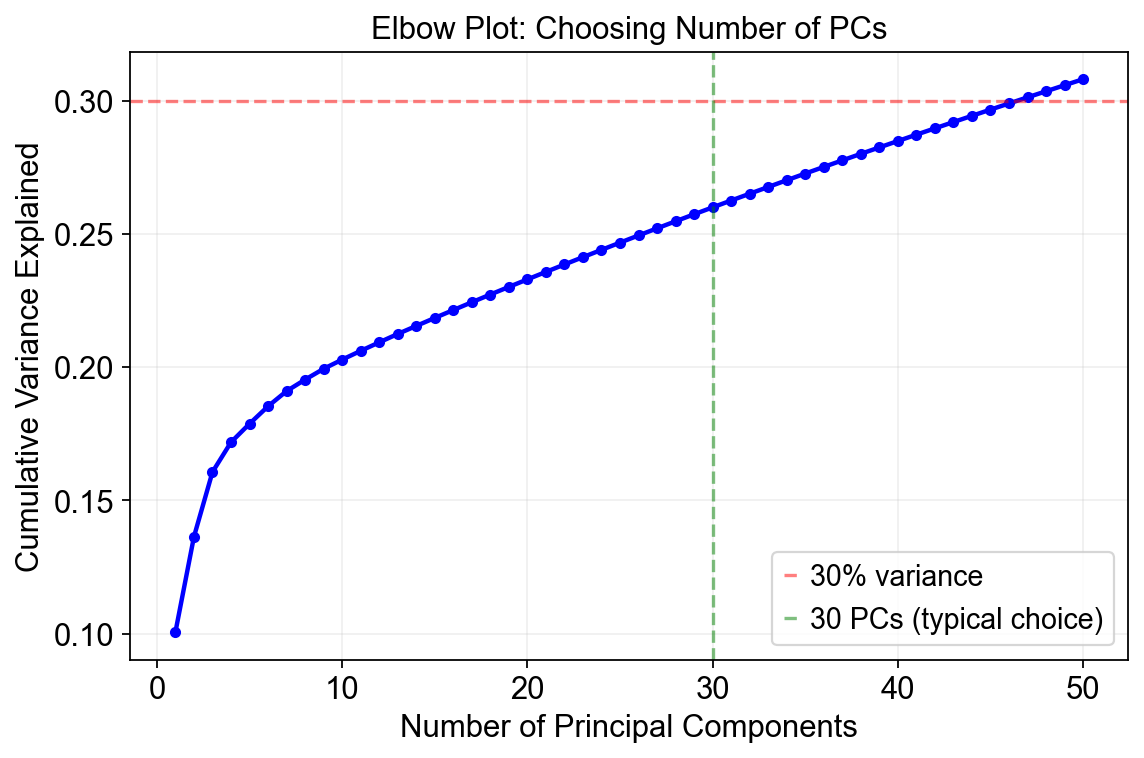

Elbow plot created!
Recommendation: Use ~30 PCs for downstream analysis


In [11]:
# Elbow plot
fig, ax = plt.subplots(figsize=(8, 5))

variance_ratio = adata.uns['pca']['variance_ratio']
cumulative_var = np.cumsum(variance_ratio)

ax.plot(range(1, 51), cumulative_var, 'bo-', linewidth=2, markersize=4)
ax.axhline(y=0.3, color='r', linestyle='--', alpha=0.5, label='30% variance')
ax.axvline(x=30, color='g', linestyle='--', alpha=0.5, label='30 PCs (typical choice)')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Variance Explained')
ax.set_title('Elbow Plot: Choosing Number of PCs')
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig(f'{results_dir}03_pca_elbow_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Elbow plot created!")
print(f"Recommendation: Use ~30 PCs for downstream analysis")

## 4. Visualize PCA Space

Plot cells in the first few principal components, colored by QC metrics.

**Note**: This is a linear projection and may not show clear structure. UMAP (next) will be better!

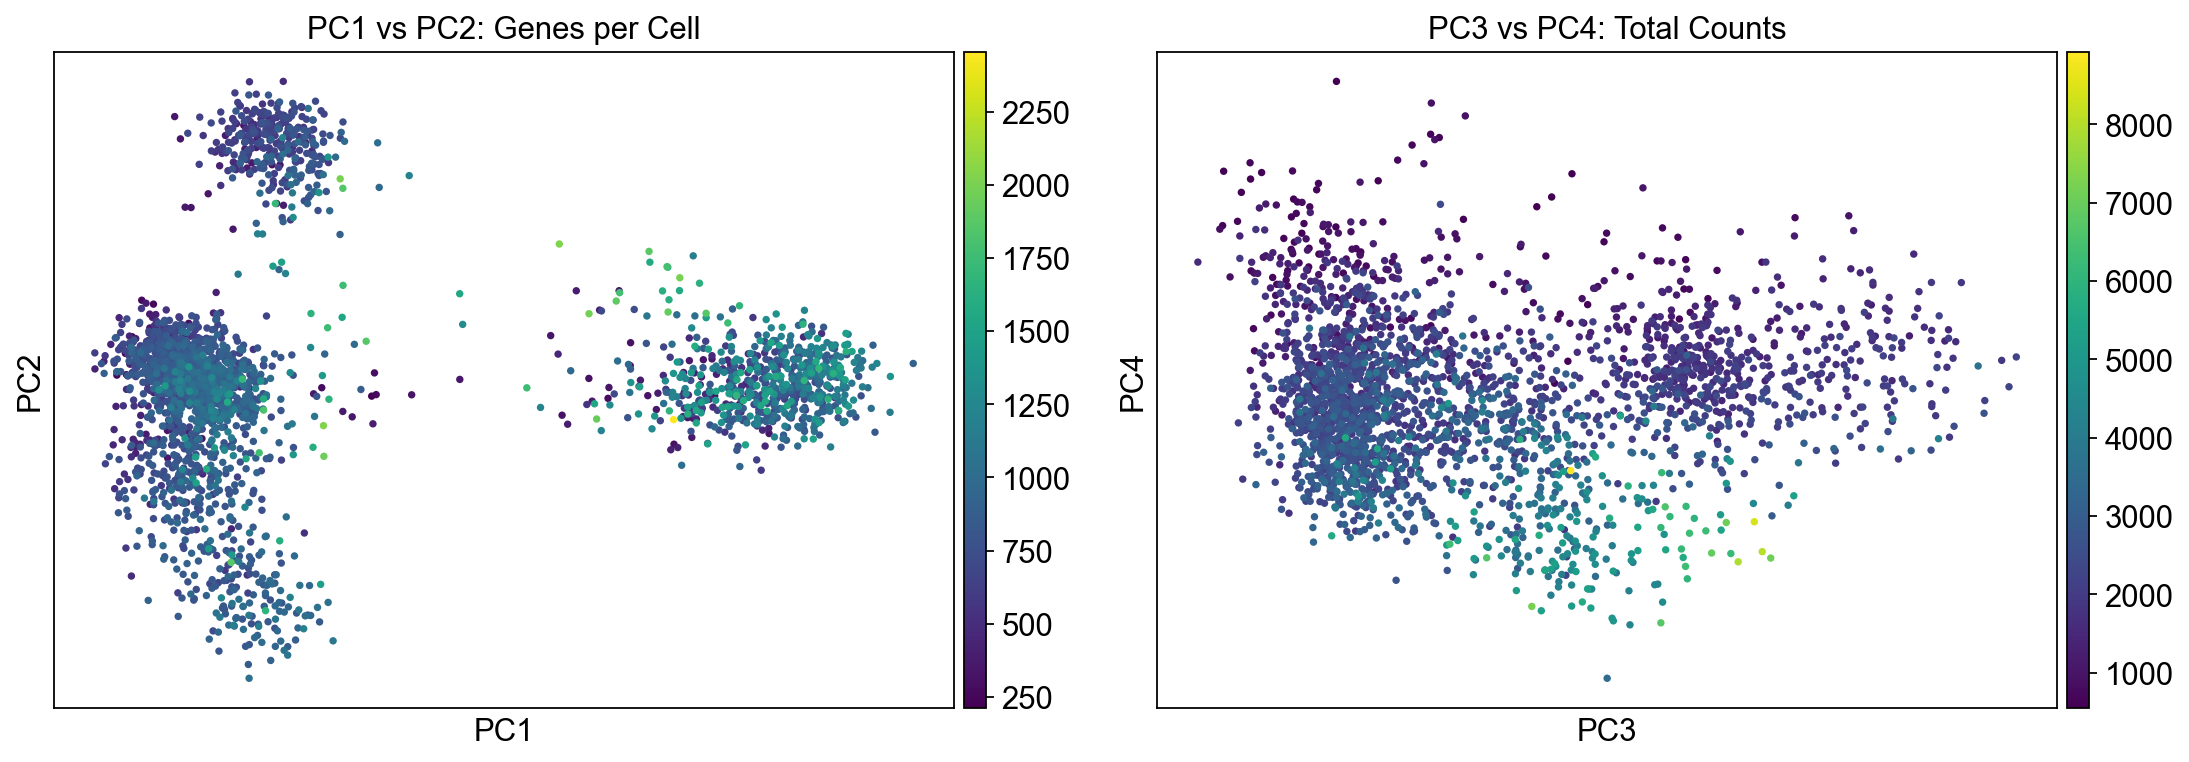

PCA scatter plots created


In [13]:
# PCA scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 vs PC2, colored by n_genes
sc.pl.pca(adata, color='n_genes_by_counts', components=['1,2'], ax=axes[0], show=False, title='PC1 vs PC2: Genes per Cell')

# PC3 vs PC4, colored by total_counts
sc.pl.pca(adata, color='total_counts', components=['3,4'], ax=axes[1], show=False, title='PC3 vs PC4: Total Counts')

plt.tight_layout()
plt.savefig(f'{results_dir}03_pca_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("PCA scatter plots created")

## 5. Compute Neighborhood Graph

Before UMAP, we build a **k-nearest neighbor (KNN) graph**:

**What it does**:
- For each cell, find its k nearest neighbors in PCA space
- Creates a graph connecting similar cells
- Used by both UMAP and clustering algorithms

**Parameters**:
- `n_neighbors`: Number of neighbors (default: 15)
  - Smaller: More local structure, tighter clusters
  - Larger: More global structure, looser clusters
- `n_pcs`: Number of PCs to use (we'll use 30)

In [14]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

print("✅ Neighborhood graph computed!")
print(f"Using {30} principal components")
print(f"Each cell connected to {15} nearest neighbors")

computing neighbors
    using 'X_pca' with n_pcs = 30


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
✅ Neighborhood graph computed!
Using 30 principal components
Each cell connected to 15 nearest neighbors


## 6. UMAP (Uniform Manifold Approximation and Projection)

### What is UMAP?

**UMAP** is a non-linear dimensionality reduction technique that:
- Preserves **local** structure (nearby cells stay nearby)
- Preserves **global** structure better than t-SNE
- Faster than t-SNE
- More reproducible than t-SNE
- **Current gold standard** for single-cell visualization

### How it works (simplified):

1. Uses the neighbor graph we just computed
2. Finds a 2D representation that preserves the graph structure
3. Similar cells cluster together

### Key parameter:

- `min_dist`: Minimum distance between points in 2D (0.1-0.5)
  - Smaller (0.1): Tighter, more separated clusters
  - Larger (0.5): More spread out, overlapping clusters
  - Default: 0.5

In [16]:
# Compute UMAP
sc.tl.umap(adata, min_dist=0.3)

print("✅ UMAP complete!")
print(f"Data reduced: {adata.obsm['X_pca'].shape[1]} PCs → 2D UMAP coordinates")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)
✅ UMAP complete!
Data reduced: 50 PCs → 2D UMAP coordinates


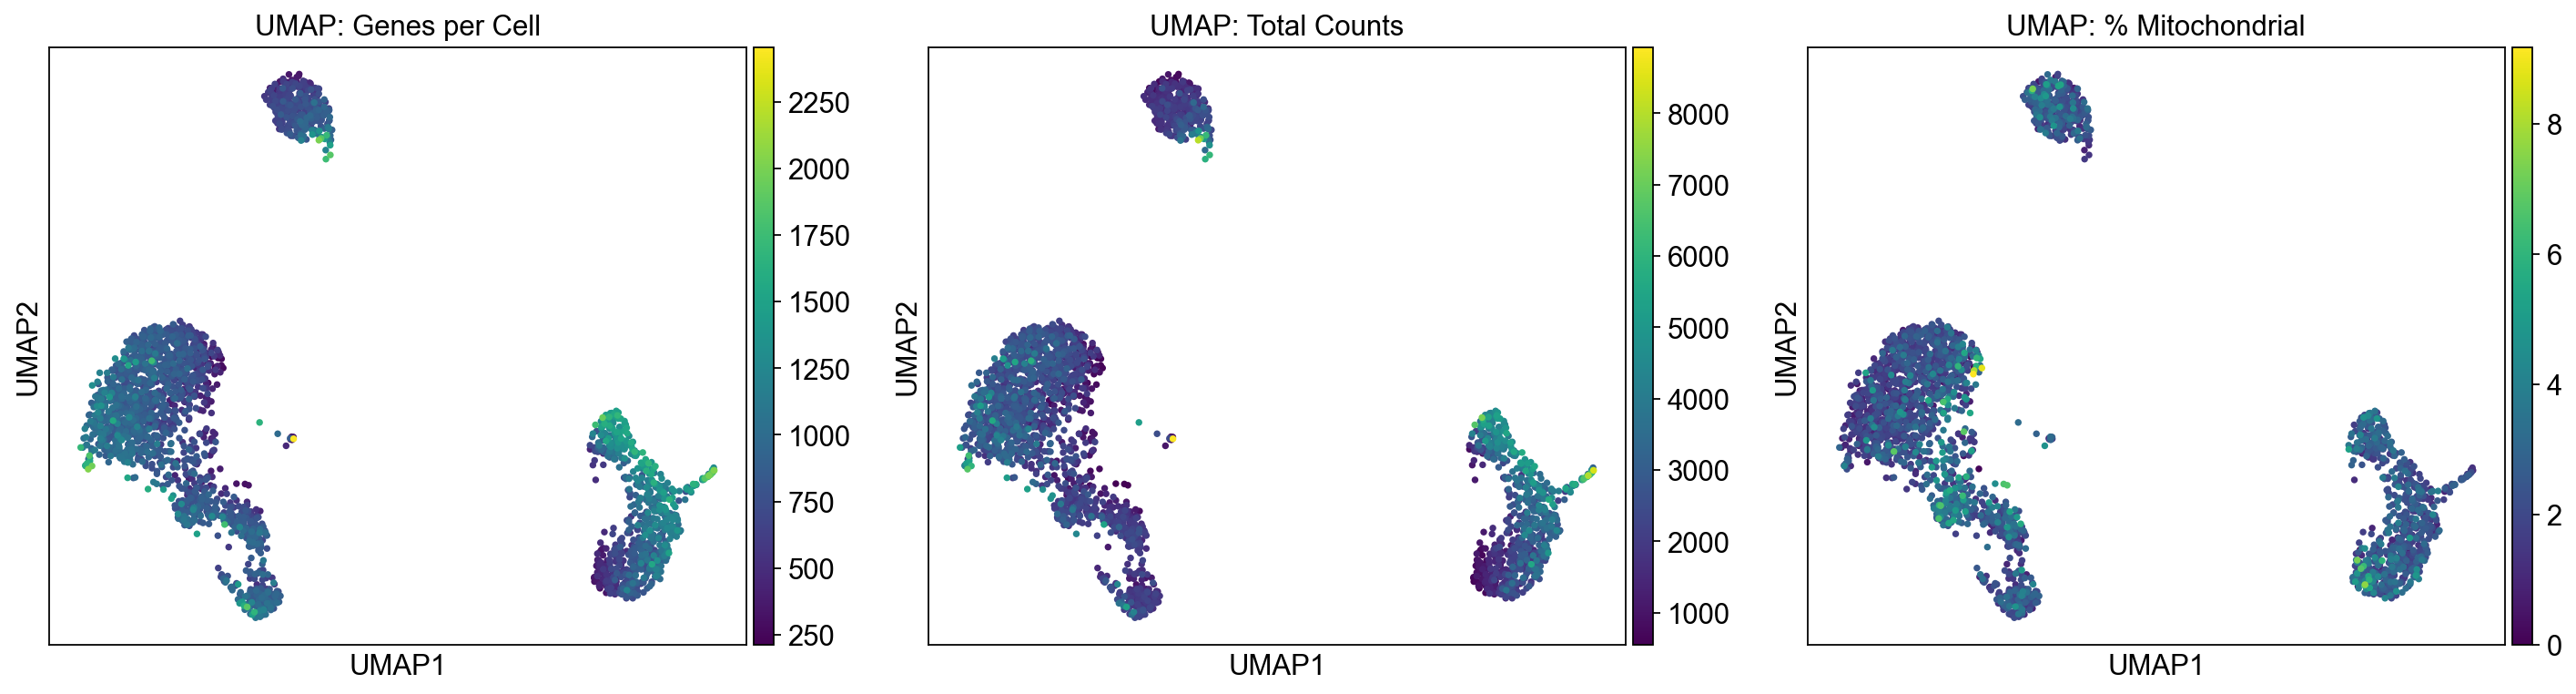

UMAP visualization colored by QC metrics
Look for patterns: Do cells cluster by biological features or technical artifacts?


In [18]:
# Visualize UMAP colored by QC metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Color by number of genes
sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[0], show=False, title='UMAP: Genes per Cell')

# Color by total counts
sc.pl.umap(adata, color='total_counts', ax=axes[1], show=False, title='UMAP: Total Counts')

# Color by % mitochondrial
sc.pl.umap(adata, color='pct_counts_mt', ax=axes[2], show=False, title='UMAP: % Mitochondrial')

plt.tight_layout()
plt.savefig(f'{results_dir}03_umap_qc_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("UMAP visualization colored by QC metrics")
print("Look for patterns: Do cells cluster by biological features or technical artifacts?")

## 7. t-SNE (Alternative Visualization)

### What is t-SNE?

**t-SNE** (t-Distributed Stochastic Neighbor Embedding):
- Another non-linear dimensionality reduction
- Excellent at preserving **local** structure
- Creates very tight, well-separated clusters

### UMAP vs t-SNE:

| Feature | UMAP | t-SNE |
|---------|------|-------|
| **Speed** | Faster | Slower |
| **Global structure** | Better preserved | Less preserved |
| **Reproducibility** | More consistent | More variable (random) |
| **Cluster separation** | Moderate | Very tight |
| **Current preference** | Preferred | Still useful for exploration |

**Note**: We'll use UMAP for the rest of the analysis, but t-SNE is shown for comparison.

In [19]:
# Compute t-SNE
sc.tl.tsne(adata, n_pcs=30)

print("t-SNE complete!")

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:04)
t-SNE complete!


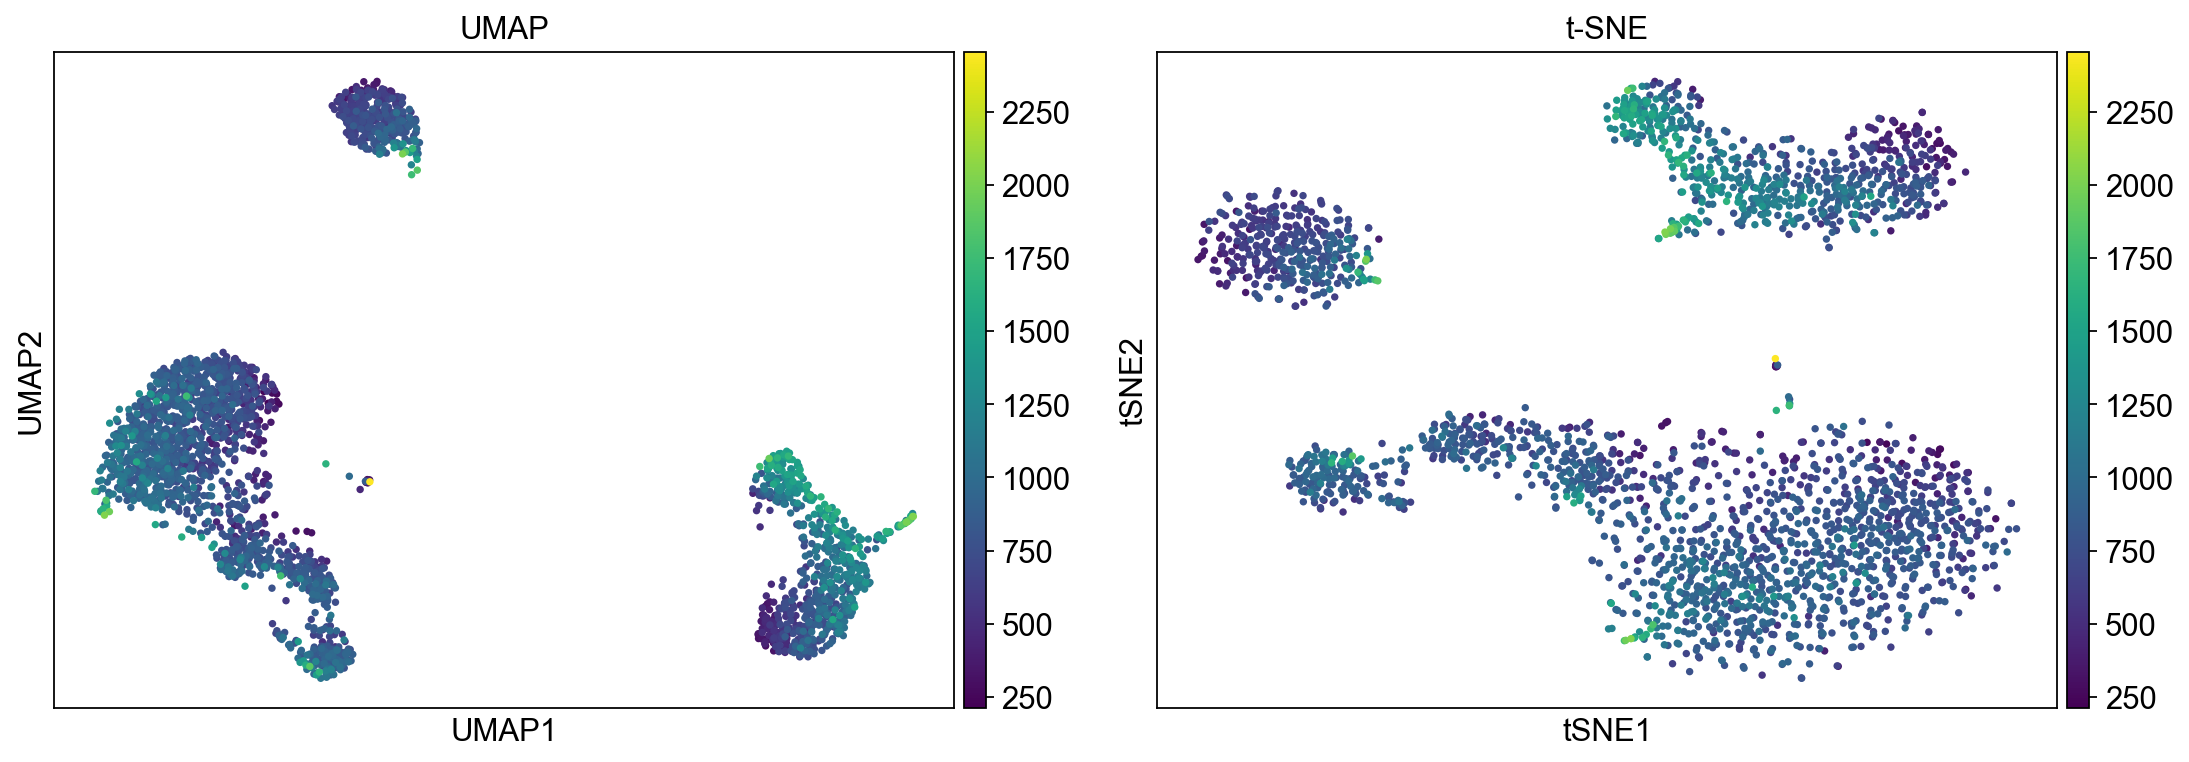

📊 UMAP vs t-SNE comparison
💡 Notice: t-SNE creates tighter, more separated clusters
💡 UMAP preserves more global structure


In [20]:
# Compare UMAP vs t-SNE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[0], show=False, title='UMAP')
sc.pl.tsne(adata, color='n_genes_by_counts', ax=axes[1], show=False, title='t-SNE')

plt.tight_layout()
plt.savefig(f'{results_dir}03_umap_vs_tsne.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 UMAP vs t-SNE comparison")
print("💡 Notice: t-SNE creates tighter, more separated clusters")
print("💡 UMAP preserves more global structure")

## 8. Interpret Principal Components

Which genes contribute most to each PC? This helps understand what biological processes each PC captures.

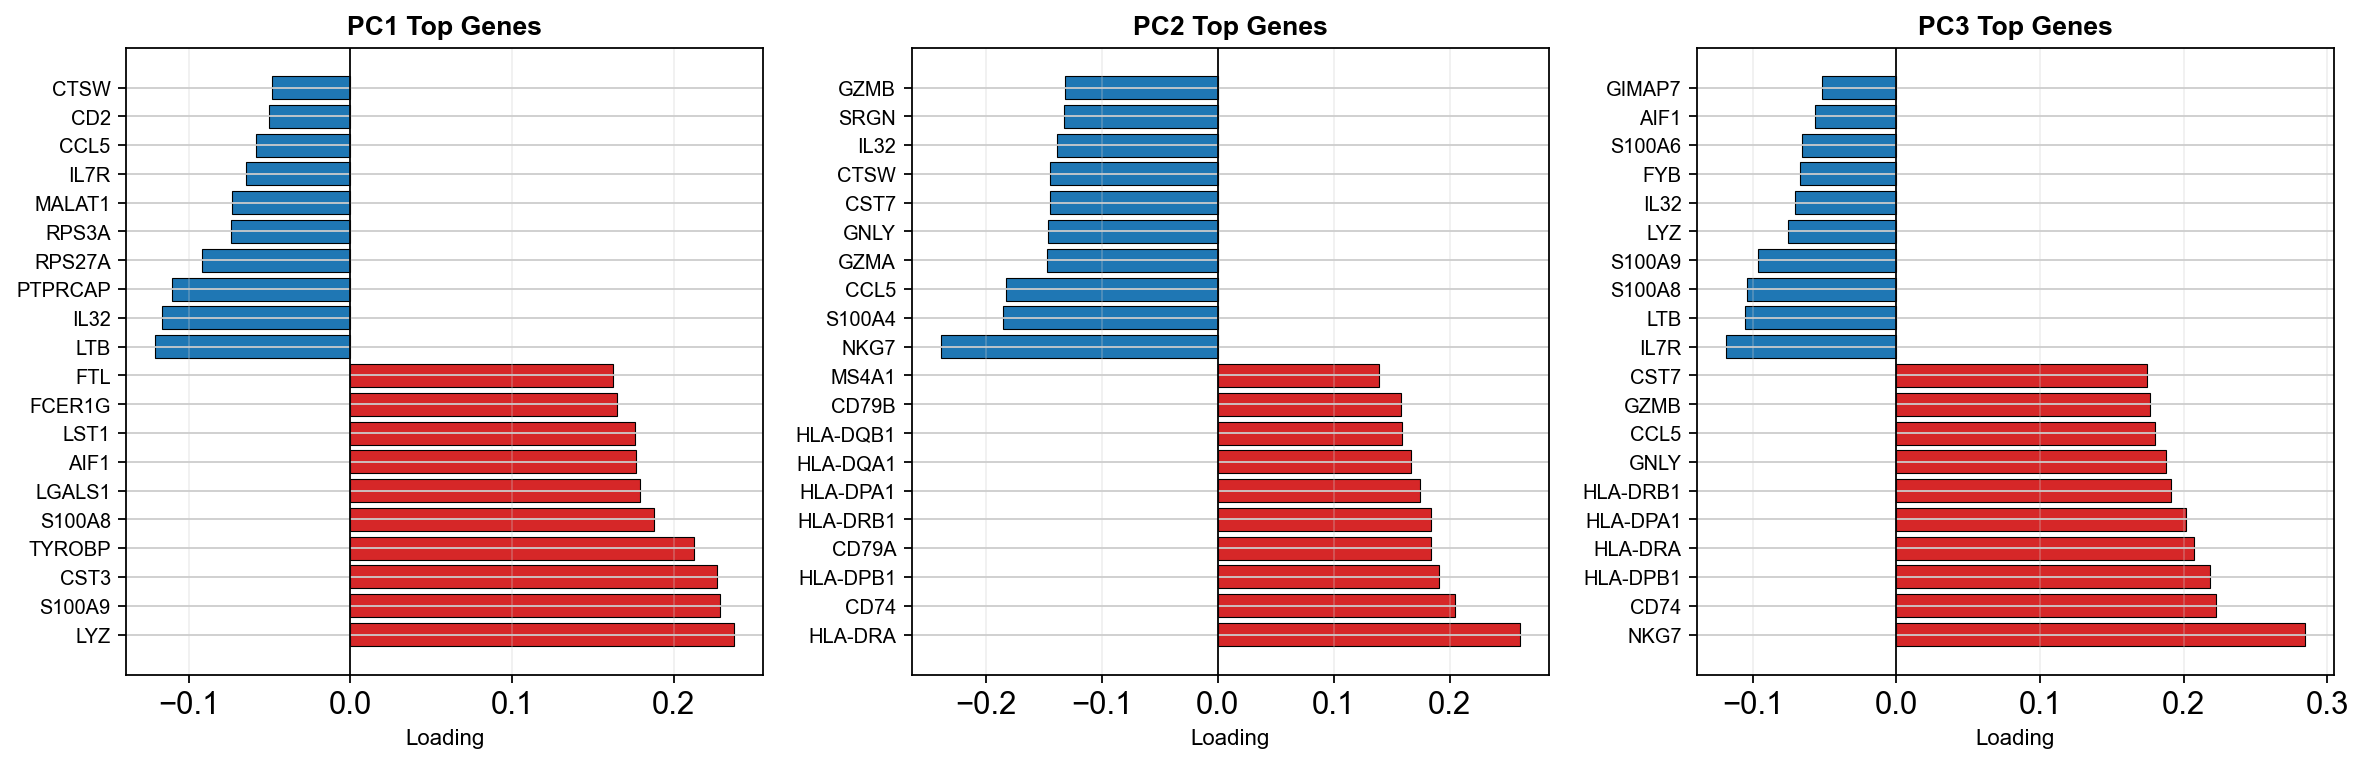

Top genes contributing to PC1, PC2, PC3
Red bars: Positive loadings (high in one direction)
Blue bars: Negative loadings (high in opposite direction)
These genes drive the major axes of variation in your data


In [23]:
# Better visualization of PCA loadings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get top genes for each PC
n_genes = 10
pcs_to_show = [0, 1, 2]  # PC1, PC2, PC3

for idx, pc in enumerate(pcs_to_show):
    # Get loadings for this PC
    loadings = adata.varm['PCs'][:, pc]
    
    # Get top positive and negative genes
    top_pos_idx = np.argsort(loadings)[-n_genes:][::-1]
    top_neg_idx = np.argsort(loadings)[:n_genes]
    
    # Combine
    top_idx = np.concatenate([top_pos_idx, top_neg_idx])
    top_genes = adata.var_names[top_idx]
    top_loadings = loadings[top_idx]
    
    # Create colors (positive = red, negative = blue)
    colors = ['#d62728' if x > 0 else '#1f77b4' for x in top_loadings]
    
    # Plot horizontal bar chart
    y_pos = np.arange(len(top_genes))
    axes[idx].barh(y_pos, top_loadings, color=colors, edgecolor='black', linewidth=0.5)
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(top_genes, fontsize=9)
    axes[idx].set_xlabel('Loading', fontsize=10)
    axes[idx].set_title(f'PC{pc+1} Top Genes', fontsize=12, fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_dir}03_pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

print("Top genes contributing to PC1, PC2, PC3")
print("Red bars: Positive loadings (high in one direction)")
print("Blue bars: Negative loadings (high in opposite direction)")
print("These genes drive the major axes of variation in your data")

## 9. Save Results

Save the data with all dimensionality reduction coordinates.

In [24]:
# Save data with dimensionality reduction
adata.write(f'{data_dir}pbmc3k_dimred.h5ad')

print("✅ Data saved with dimensionality reduction!")
print(f"File: {data_dir}pbmc3k_dimred.h5ad")
print(f"\n📊 Embeddings computed:")
print(f"  - PCA: {adata.obsm['X_pca'].shape}")
print(f"  - UMAP: {adata.obsm['X_umap'].shape}")
print(f"  - t-SNE: {adata.obsm['X_tsne'].shape}")

✅ Data saved with dimensionality reduction!
File: ../data/pbmc3k_dimred.h5ad

📊 Embeddings computed:
  - PCA: (2689, 50)
  - UMAP: (2689, 2)
  - t-SNE: (2689, 2)


## 📋 Summary

### ✅ What we accomplished:

1. **Loaded preprocessed data** with PCA (50 components)
2. **Visualized PCA variance** (~26% in first 30 PCs)
3. **Created elbow plot** to choose number of PCs
4. **Visualized PCA space** (linear projection)
5. **Built neighborhood graph** (k=15 neighbors, 30 PCs)
6. **Computed UMAP** (2D non-linear projection)
7. **Computed t-SNE** (alternative 2D projection)
8. **Compared UMAP vs t-SNE**
9. **Interpreted PCs** (top contributing genes)
10. **Saved results** for clustering

### 📊 Dimensionality Reduction : 
13,671 genes → 2,000 HVGs → 50 PCs → 2D (UMAP/t-SNE)



### 🎯 Key Insights:

- **PCA**: Linear reduction, captures ~26% variance in 30 PCs
- **Neighborhood graph**: Connects similar cells, basis for UMAP/clustering
- **UMAP**: Non-linear, preserves local + global structure ✅ Preferred
- **t-SNE**: Non-linear, very tight clusters, good for exploration

### 🔍 What to look for in UMAP:

- **Distinct clusters**: Suggest different cell types
- **Gradients**: Suggest continuous states (differentiation, cell cycle)
- **Technical artifacts**: Cells clustering by QC metrics (bad!)

### 🚀 Next Steps: Notebook 04 - Clustering

In the next notebook, we will:
1. **Leiden clustering** - Identify cell populations
2. **Evaluate clustering quality**
3. **Visualize clusters** on UMAP
4. **Explore cluster composition**

---

**🎉 Excellent work! Your data is now visualized and ready for clustering!**